# Notebook Objective
The goal of this notebook is to create an image search engine.
As input, the user can provide either a text query or the path to an image (even an embeddings of texts or image),
and as output, the system returns images that are semantically similar to the given text or image.

**Example**:

    - If the input is the word “Trump” or a picture of Trump,
    - The output will display images of Trump or anything related to him 
        - for instance, the U.S. flag, a map of the United States, or the Congress building.

# Test Datasets

We will test the search engine on two datasets:

1. **Recognition of the Palestinian State (08/13 – 08/29)**  
   This dataset was collected following France’s recognition of the State of Palestine.  
   It includes both **texts and their associated images**, totaling **5,055 images**.

2. **September 10 Demonstrations (08/20 – ~10/10)**  
   This dataset was collected during the period surrounding the **September 10 protest in France**.  
   It also contains **texts and their related images**, totaling **41,942 images**.

Only the **image URLs** are stored — the images themselves will be **downloaded dynamically** during processing.

In [1]:
from helper_functions import *

from tqdm import tqdm  
import pandas as pd 
import numpy as np 
import warnings 
import logging  
import csv
import os

warnings.filterwarnings("ignore")
logging.getLogger("transformer").setLevel(logging.ERROR)
logging.getLogger("PIL").setLevel(logging.WARNING)



from dotenv import load_dotenv
load_dotenv()        
path = os.getenv("path_folder")


c:\Users\anass\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parametres

In [2]:
path_folder_images_name = os.path.join(path, "img_data")
path_folder_images_urls = os.path.join(path, "img_urls")
path_folder_images_embeddings = os.path.join(path, "img_embeddings")

subject = '10_septembre' # ou 'reconnaissance_france_palestine'
image_dir = os.path.join(path_folder_images_name, subject)


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Folder and Variable Configuration

- **`path_folder_images_name`** → the **directory path** where the downloaded images will be saved (to be adapted as needed).  
- **`path_folder_images_urls`** → the **directory path** where the files containing the **image URLs** are stored (to be adapted as needed).  
- **`path_folder_images_embeddings`** → the **directory path** where the embeddings will be saved as parquet file (to be adapted as needed).
- **`subject`** → defines the dataset used, either `"10_septembre"` or `"reconnaissance_france_palestine"` (to be adapted).  
- **`image_dir`** → the **subfolder name** inside `path_folder_images_name` where the images will actually be downloaded.


In [ ]:
df_urls = pd.read_csv(fr"{path_folder_images_urls}\{subject}.csv")
urls = df_urls.url.to_list()


# execute one time to download data
results, failed = parallel_download(urls, path_folder_images_name, subject, return_failed_csv=True, timeout=2) # Parallel image downloading with error and retry handling

Since some images on social media may **no longer exist** or may cause **request errors**, setting **`return_failed_csv = True`** enables the creation of a **CSV file** that lists all **URLs that could not be downloaded** during the process.

The code above should be executed **only once**.  
After running it, all images will be **downloaded locally**, and can then be **reused directly** in subsequent steps without re-downloading.

# Applying a sota CLIP Model 

We apply the model **`laion/CLIP-ViT-H-14-laion2B-s32B-b79K`** to generate embeddings for semantic comparison and retrieval.

In [3]:
# Load model directly
processor, model = upload_clip("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

 Modèle laion/CLIP-ViT-H-14-laion2B-s32B-b79K chargé sur cuda


In [ ]:
dict_clip = encode_with_clip(image_dir=image_dir, processor=processor, model=model, batch_size=16)
df = dict_clip['image_embeddings']
df.to_parquet(fr"{path_folder_images_embeddings}/{subject}.parquet", index=False)

Préparation des chemins d'images...


Image batches: 100%|██████████| 2490/2490 [19:09<00:00,  2.17it/s]


When the model is applied, the **image embeddings** are saved as a **Parquet file**.  
The code above should be executed **only once**.  
After running it, all embeddings will be **stored locally** and can be **reused** in later steps without the need to recompute them. 

To do so execute the next cell.

In [4]:
df = pd.read_parquet(f"{path_folder_images_embeddings}/{subject}.parquet")

# Search Engine 

### 10 septembre

Recherche par texte...
Encodage du texte...


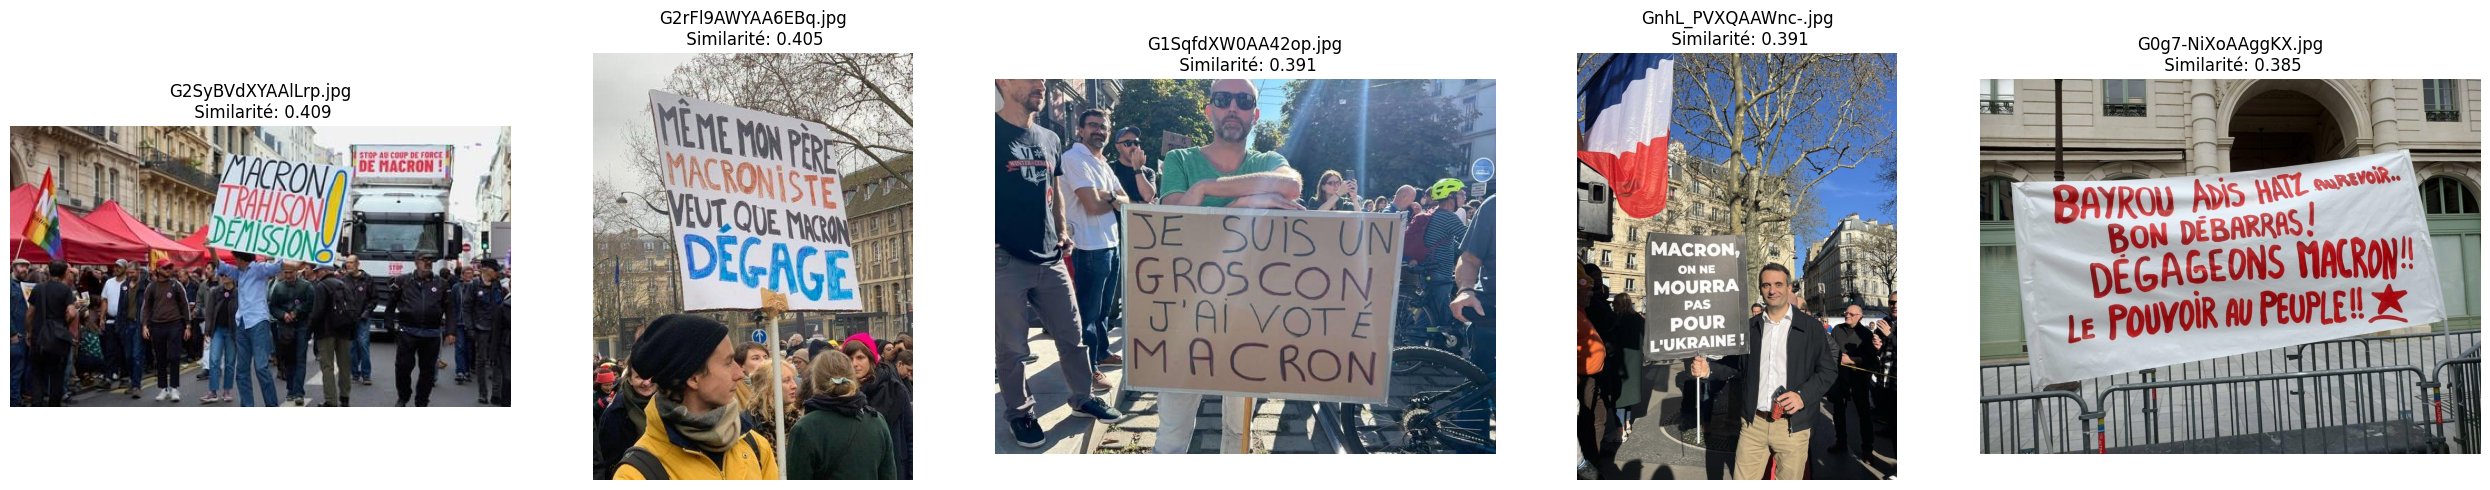

Recherche par texte...
Encodage du texte...


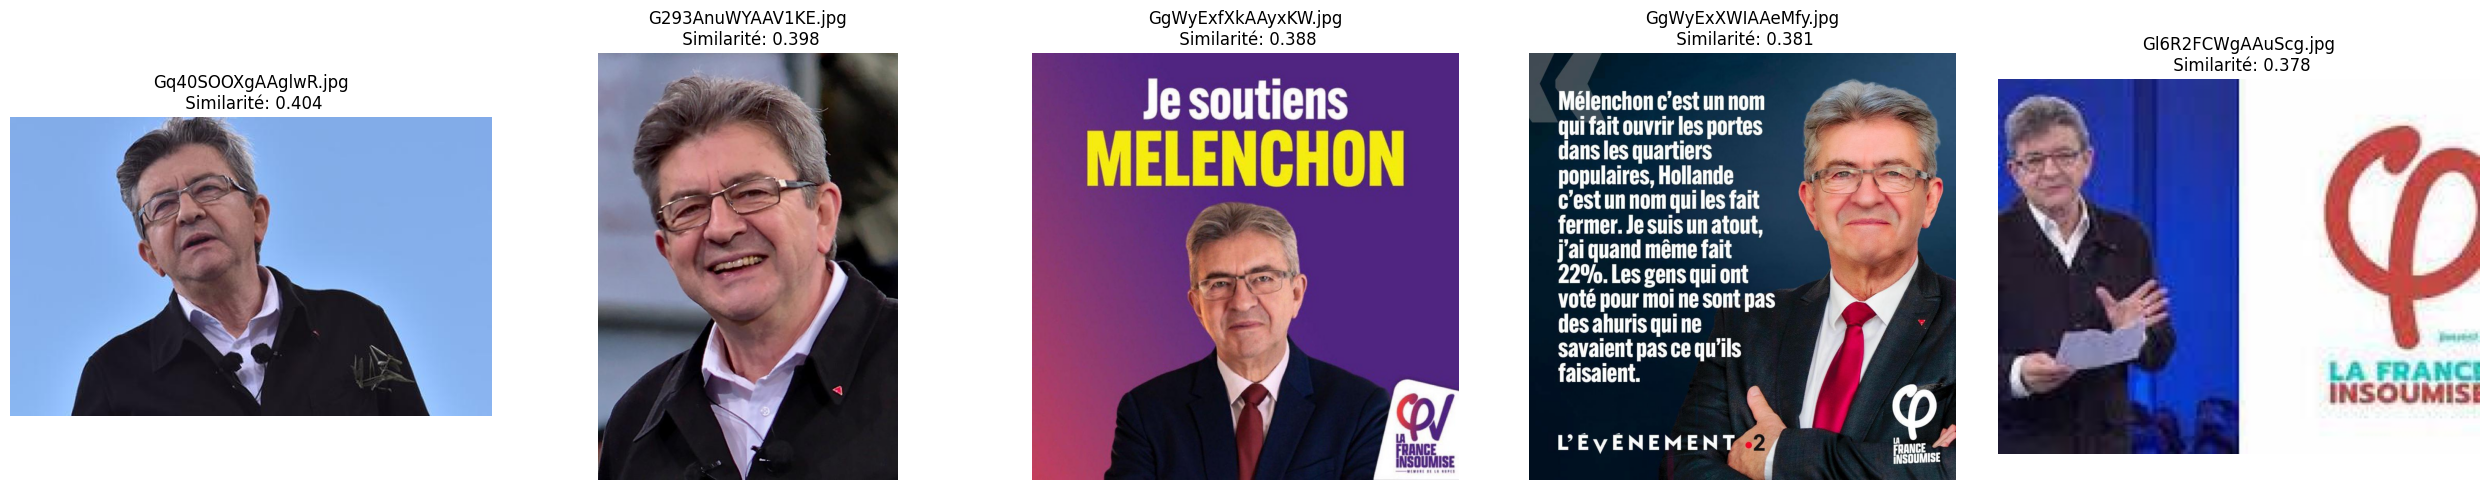

The image which we're looking for similars:


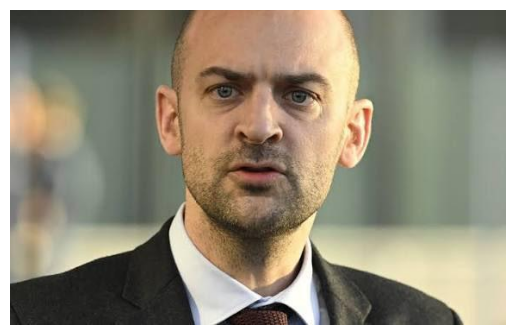

Recherche par image...
Préparation des chemins d'images...


Image batches: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


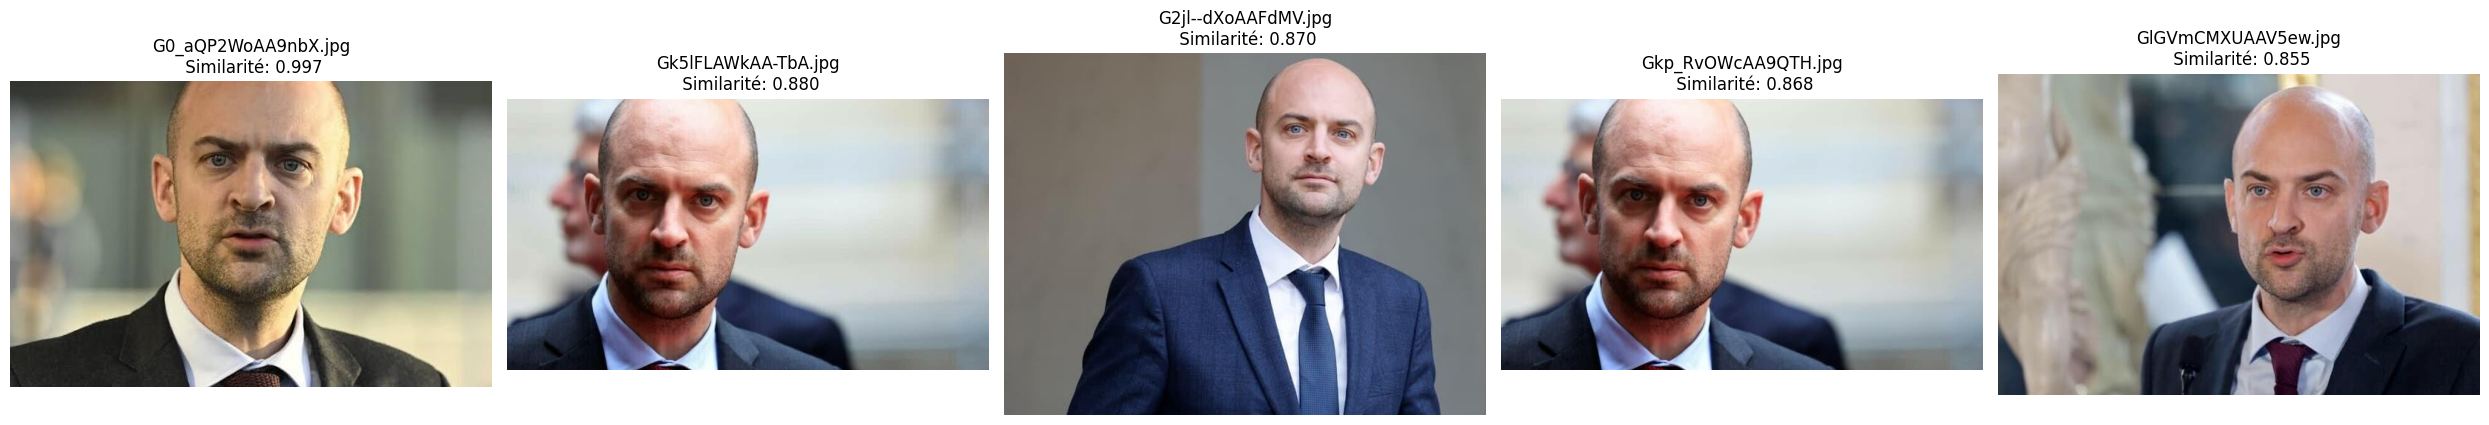

In [5]:
search_engine(query="Manifestation contre macron", df=df, model=model, processor=processor, image_dir=image_dir, k=5) # k is the image number to display
search_engine(query="Jean-Luc Mélenchon", df=df, model=model, processor=processor, image_dir=image_dir, k=5) 

image_path = fr"{image_dir}\G0_aQP2WoAA9nbX.jpg"
print("The image which we're looking for similars:")
show_image(image_path)
search_engine(query=image_path, df=df, model=model, processor=processor, image_dir=image_dir, k=5) 

### Palestine recognition by France

In [6]:
subject = 'reconnaissance_france_palestine'
image_dir = os.path.join(path_folder_images_name, subject)
df = pd.read_parquet(f"{path_folder_images_embeddings}/{subject}.parquet")

Recherche par texte...
Encodage du texte...


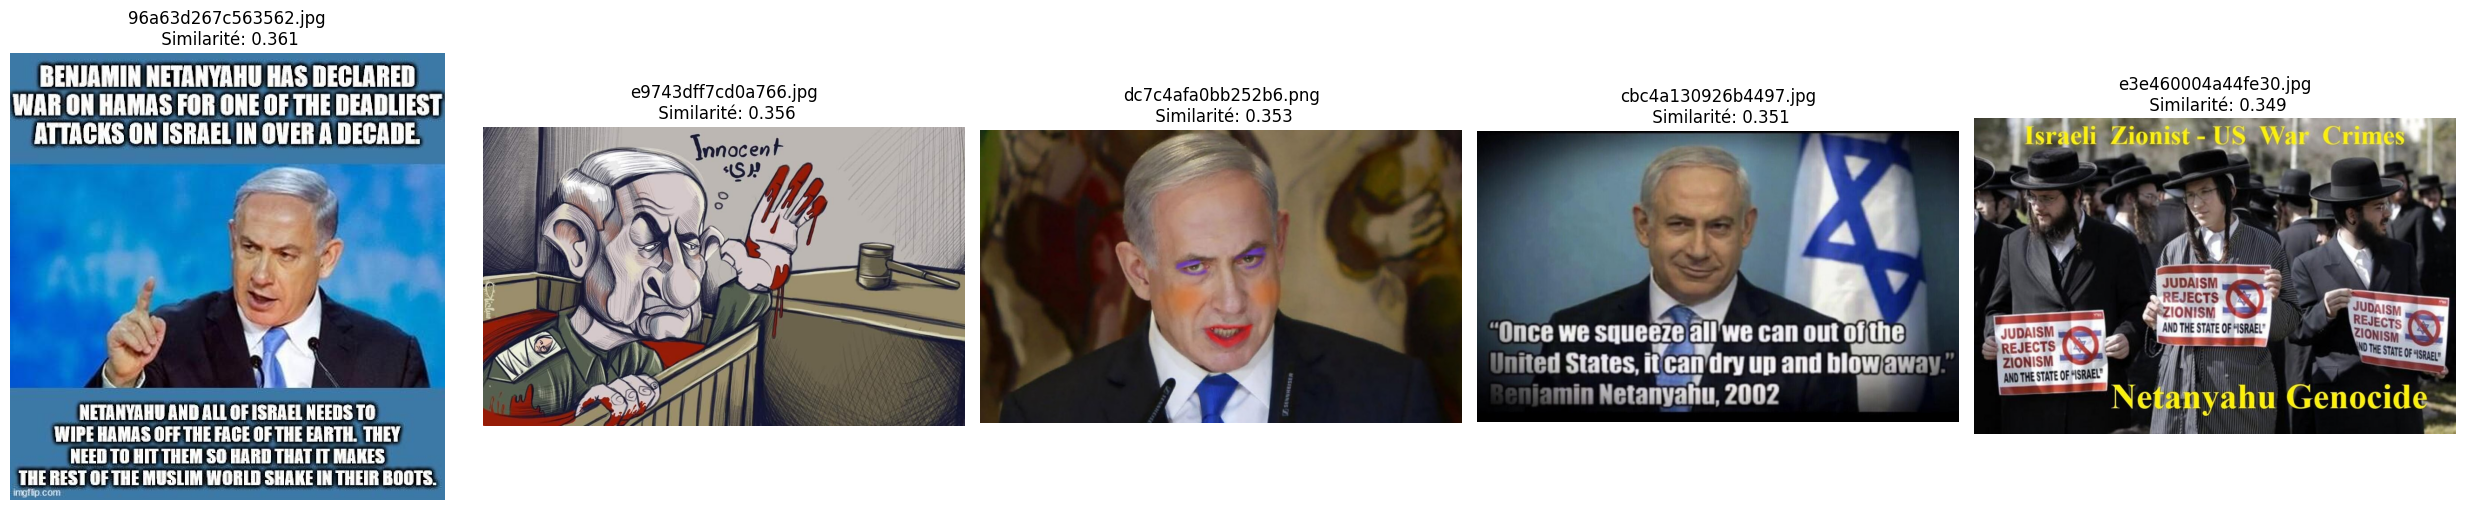

Recherche par texte...
Encodage du texte...


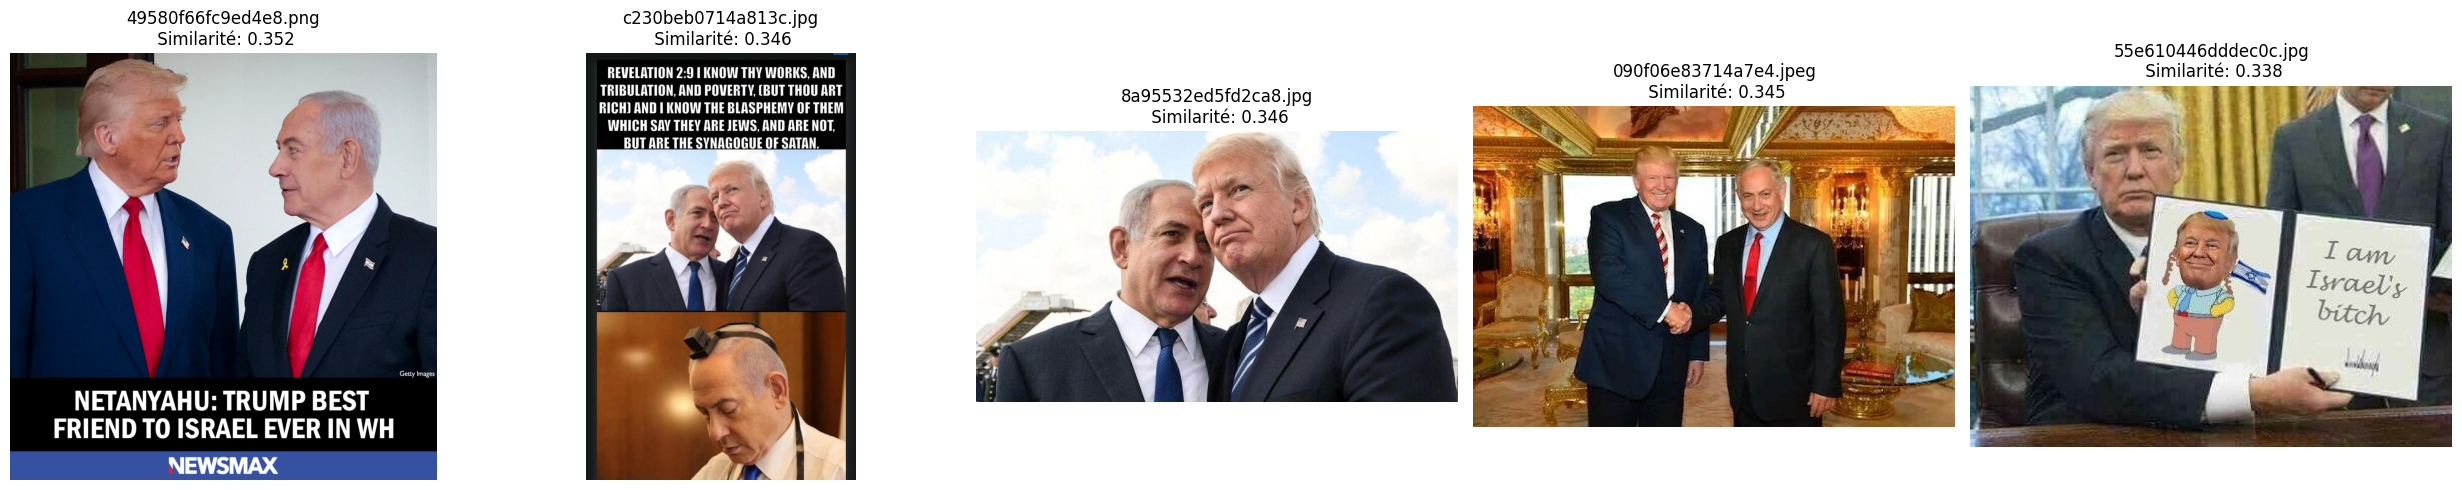

The image which we're looking for similars:


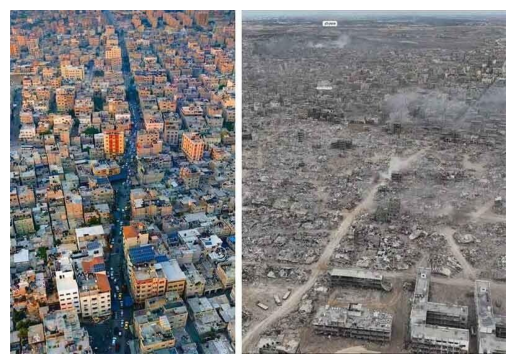

Recherche par image...
Préparation des chemins d'images...


Image batches: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


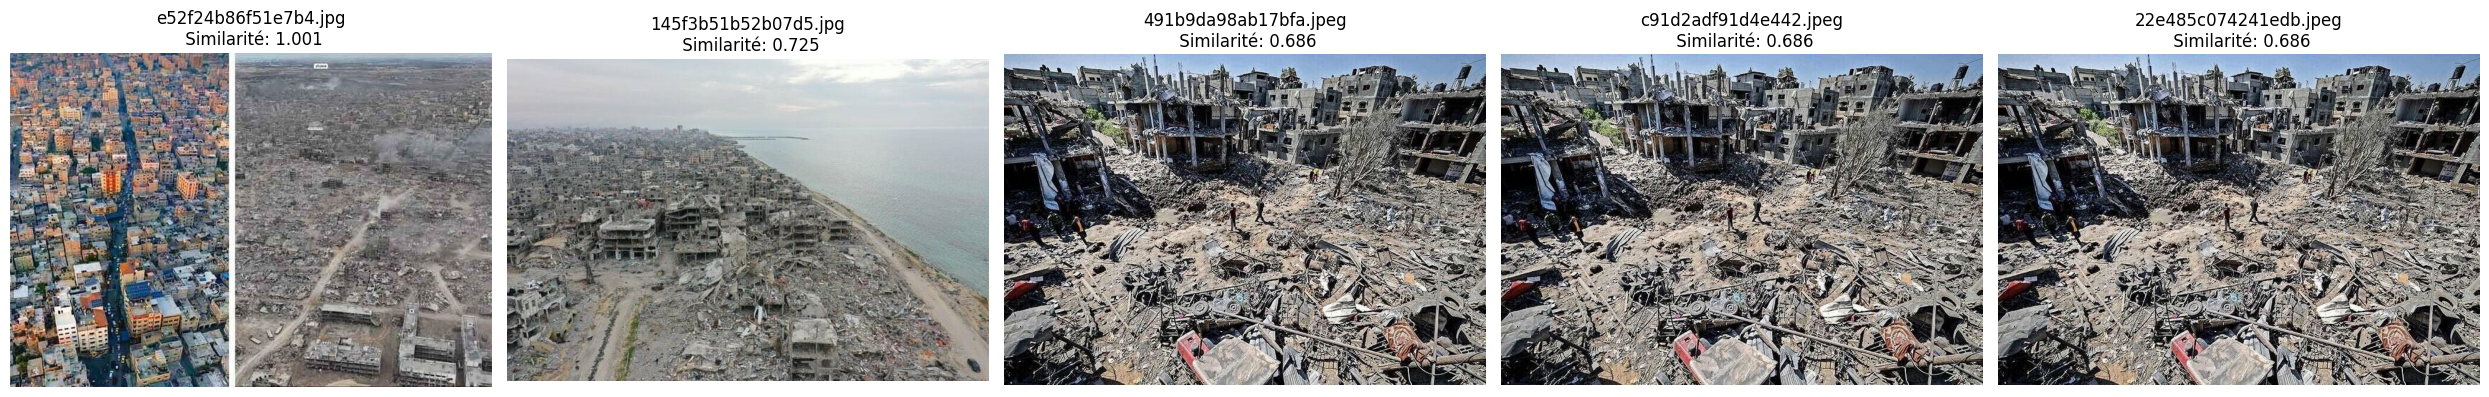

In [11]:
search_engine(query="Netanyahu is committing a genocide", df=df, model=model, processor=processor, image_dir=image_dir, k=5) # Satellite, person wearing a mask, trump.... 
search_engine(query="trump support Netanyahu", df=df, model=model, processor=processor, image_dir=image_dir, k=5) 


image_path = fr"{image_dir}\e52f24b86f51e7b4.jpg"
print("The image which we're looking for similars:")
show_image(image_path)
search_engine(query=image_path, df=df, model=model, processor=processor, image_dir=image_dir, k=5) 



# Conclusion

We can clearly see that the image search engine performs **extremely well**. Its strength lies not only in retrieving images that are **semantically related**  
to the input text or image, but also in handling cases where the image is a **screenshot of text**.  
If the screenshot contains text discussing the same topic as the input query, the model successfully identifies it as if it were equipped with an OCR system.  

In reality, this behavior comes from the fact that the model used is a **state-of-the-art (SOTA)** architecture, trained on an **enormous number of text–image pairs**.  
Through this large-scale training, it has learned to recognize **letter patterns and textual structures**, allowing it to behave as though it **understands written text within images**.
